In [1]:
!python --version
%pip install ../ # Use local jaxDSP package rather than published one.

Python 3.12.3
Processing /Users/khiner/Development/jaxdsp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jaxdsp: filename=jaxdsp-0.3.1-py3-none-any.whl size=22243 sha256=5098a5c7acd15310313acf8ebf960711a678c20f56a8435b4c5c5cf8f8d5bfa6
  Stored in directory: /private/var/folders/ml/r9zrbg2s0hq7cyxx40fw_k800000gn/T/pip-ephem-wheel-cache-1k0y0s57/wheels/f1/a5/b7/313c75bc0afa33627e970f8339fd2e2d68a1dc70b987148cef
Successfully built jaxdsp
  Attempting uninstall: jaxdsp
    Found existing installation: jaxdsp 0.3.1
    Uninstalling jaxdsp-0.3.1:
      Successfully uninstalled jaxdsp-0.3.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad, jit
from scipy import signal

In [3]:
from jaxdsp.loss import LossOptions, loss_fn, stft

amp = 1e-2
sample_rate = 16_000
audio = amp * (np.random.rand(sample_rate * 4).astype(np.float32) * 2.0 - 1.0)
frame_size = 2048
hop_size = 128
overlap = 1.0 - float(hop_size) / frame_size

s_np = signal.stft(audio,
                   nperseg=int(frame_size),
                   noverlap=int(overlap),
                   nfft=int(frame_size))
s_jdsp = stft(audio, frame_size=frame_size, overlap=overlap)

np.allclose(s_np[0], s_jdsp[0]), np.allclose(s_np[1], s_jdsp[1]), np.allclose(s_np[2], s_jdsp[2])

(True, True, True)

In [4]:
input_audio = jnp.zeros((2, sample_rate // 2))
target_audio = jnp.ones(input_audio.shape)

loss_value = loss_fn(input_audio, target_audio, LossOptions(
    weights={"cumsum_freq": 1.0},
    distance_types={"frequency": "L2"}
))
float(loss_value)

4.046118259429932

In [5]:
import matplotlib.pyplot as plt

@jit
def gen_sinusoid(frequency, amplitude=1.0, length_seconds=1.0):
    t = jnp.linspace(0.0, length_seconds, int(length_seconds * sample_rate))
    return amplitude * jnp.sin(2 * jnp.pi * frequency * t)

target_frequency = 443.0

def loss_for_frequency(frequency, loss_opts):
    X = gen_sinusoid(frequency)
    Y = gen_sinusoid(target_frequency)
    return loss_fn(X, Y, loss_opts)

## Need for using `cumsum` spectral loss vs simple magnitude

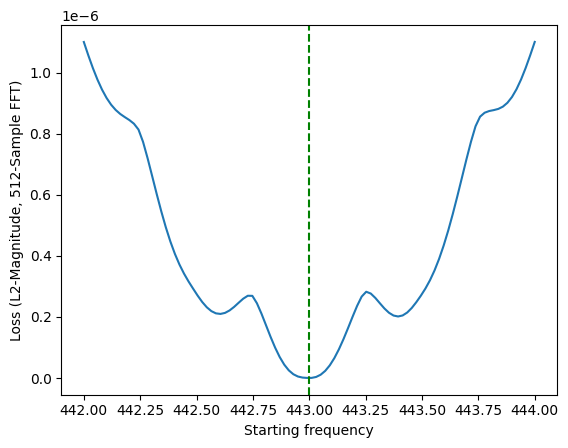

In [6]:
frequencies = np.linspace(target_frequency - 1, target_frequency + 1, 100)
plt.plot(
    frequencies,
    [loss_for_frequency(frequency, LossOptions({"magnitude": 1.0}, {"frequency": "L2"}, fft_sizes=(512,))) for frequency in frequencies],
)
plt.xlabel('Starting frequency')
plt.ylabel('Loss (L2-Magnitude, 512-Sample FFT)')
_ = plt.axvline(x=target_frequency, c="g", linestyle="--", label='Target frequency')

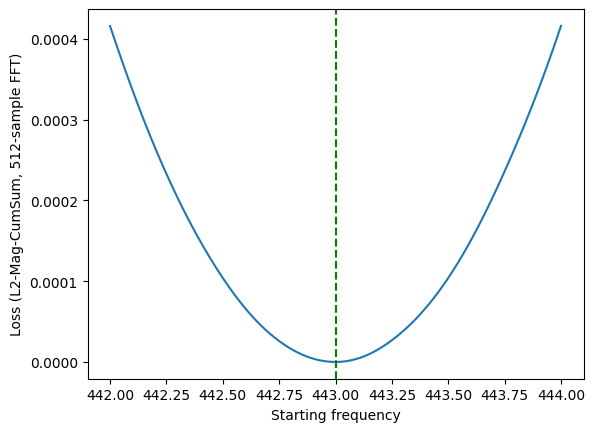

In [7]:
plt.plot(
    frequencies,
    [loss_for_frequency(frequency, LossOptions({"cumsum_freq": 1.0}, {"frequency": "L2"}, fft_sizes=(512,))) for frequency in frequencies],
)
plt.xlabel('Starting frequency')
plt.ylabel('Loss (L2-Mag-CumSum, 512-sample FFT)')
_ = plt.axvline(x=target_frequency, c="g", linestyle="--", label='Target frequency')

## Optimization smoothness tests

## Tiny loss landscape bumps in spectral loss for small FFT sizes

TODO this should make the blog post:
There are tiny non-convex ranges of the loss fn when small fft sizes are included in multi-spectral loss
Plotting est frequency vs loss with L1 distance shows a V with occasional tiny bumps.
The fn is optimizable between these bumps, but not across.
(All fft_sizes are enabled, fft_sizes=(2048, 1024, 512, 256, 128, 64), and cumsum_freq_weight=1.0)
TODO I expect to see a relationship between minimum optimizable frequency, and the fft sizes that allow smooth gradients.
Note that a 20 Hz sine sampled at 16kHz has a period of 800 samples.
TODO Show sine frequency optimization across a 20-16000 Hz range for a 44100 Hz sample rate.

UPDATE: Can repro w/o multiscale, but just a single 64-sample FFT (or anything smaller, e.g. 32).

UPDATE: Made further progress with David Braun's help, identifying that sidelobes due to window choice might be key.
Added `stft_window` option. Here are two different windows to show the difference:

### Hann window

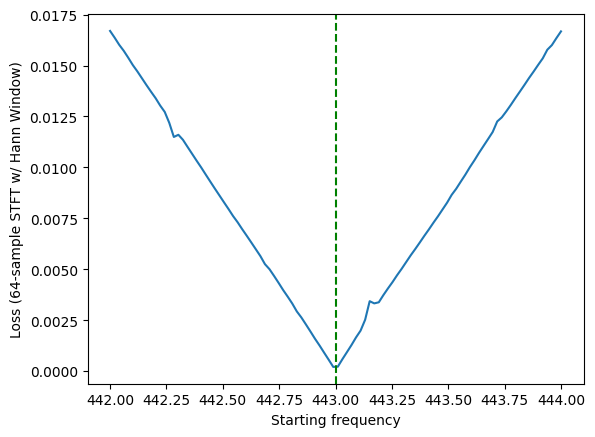

In [8]:
frequencies = np.linspace(target_frequency - 1, target_frequency + 1, 100)
plt.plot(
    frequencies,
    [loss_for_frequency(frequency, LossOptions({"cumsum_freq": 1.0}, {"frequency": "L1"}, fft_sizes=(64,), stft_window='hann')) for frequency in frequencies],
)
plt.xlabel('Starting frequency')
plt.ylabel('Loss (64-sample STFT w/ Hann Window)')
_ = plt.axvline(x=target_frequency, c="g", linestyle="--", label='Target frequency')

### Bartlett window

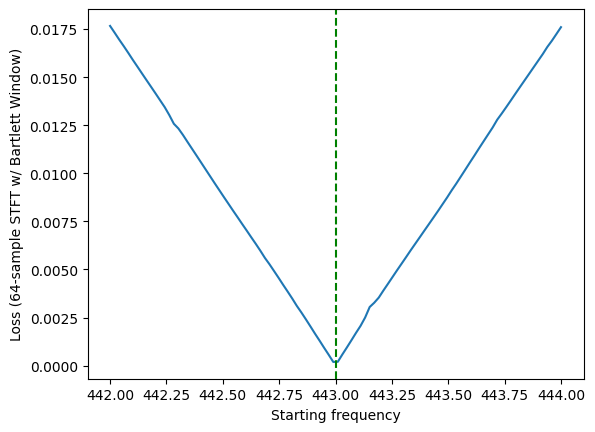

In [9]:
plt.plot(
    frequencies,
    [loss_for_frequency(frequency, LossOptions({"cumsum_freq": 1.0}, {"frequency": "L1"}, fft_sizes=(64,), stft_window='bartlett')) for frequency in frequencies],
)
plt.xlabel('Starting frequency')
plt.ylabel('Loss (64-sample STFT w/ Bartlett Window)')
_ = plt.axvline(x=target_frequency, c="g", linestyle="--", label='Target frequency')

In [10]:
estimated_frequency = 400.0

estimated_frequencies = []
losses = []
grad_fn = value_and_grad(loss_for_frequency)
learning_rate = 10.0
for _ in range(100):
    loss, grad_value = grad_fn(estimated_frequency, LossOptions({"cumsum_freq": 1.0}, {"frequency": "L2"}, fft_sizes=(512,)))
    estimated_frequency -= grad_value * learning_rate

    losses.append(loss)
    estimated_frequencies.append(estimated_frequency)

estimated_frequency

Array(416.58902, dtype=float32, weak_type=True)

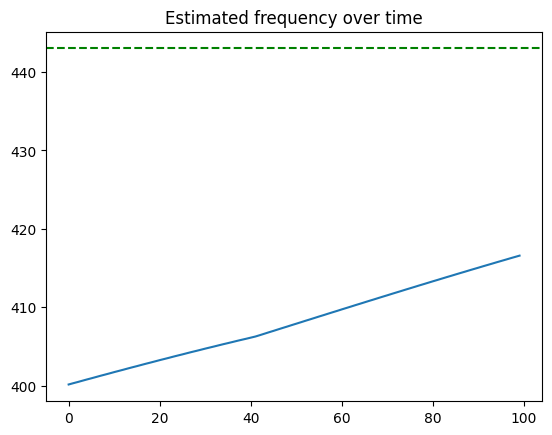

In [11]:
plt.title('Estimated frequency over time')
plt.plot(estimated_frequencies)
_ = plt.axhline(y=target_frequency, c="g", linestyle="--", label='Target frequency')

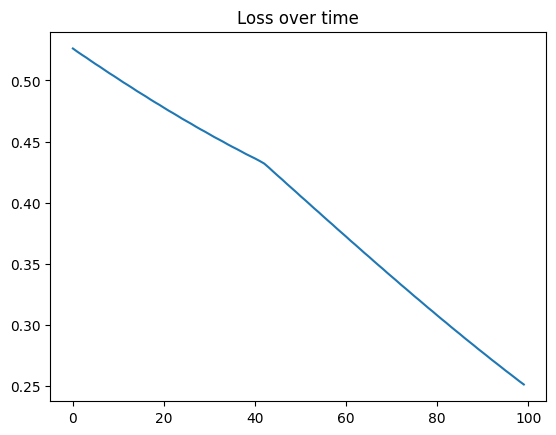

In [12]:
plt.title('Loss over time')
_ = plt.plot(losses)